# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np

training_file = "Data/train.p"
testing_file = "Data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]
image_shape = (X_train.shape[1], X_train.shape[2])
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


In [3]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

Lets take a look at an image to get an idea of what we're dealing with:

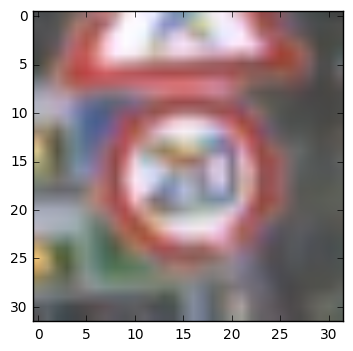

In [4]:
plt.imshow(X_train[0,...])

The image seems a little blurier than what I was expecting, but it is clear enough for me to easily see that it is a 20kph speed sign. 

## Normalization
Now that we have an idea of what an image from the dataset looks like, we need to normalize the images so that the optimizer in our model has an easier time converging. My implementation is as follows:
  * Convert the image to grayscale  
  * Equalize the histogram to account for variations in lighting conditions  
  * Divide by 255 and subtract 0.5 to clip the pixel range to [-0.5, 0.5]  

The below example shows the effect of this technique on a particularly difficult image.

Label: 6


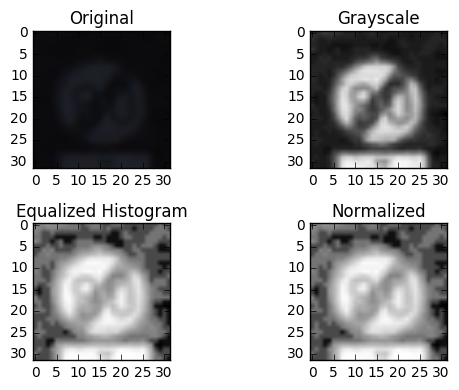

In [5]:
# Choose an image to visualize
im = 10000

# Copy the image
orig = np.copy(X_train[im,...])
print('Label: %d' % (y_train[im]))

# Convert to grayscale
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)

# Equalize the histogram
eq_gray = cv2.equalizeHist(gray)

# Normalize the values
norm_gray = eq_gray/255. - 0.5

# Plot the results
fig = plt.figure()

grid = plt.subplot(2,2,1)
grid.set_title('Original')
grid.imshow(orig)

grid = plt.subplot(2,2,2)
grid.set_title('Grayscale')
grid.imshow(gray, cmap='gray')

grid = plt.subplot(2,2,3)
grid.set_title('Equalized Histogram')
grid.imshow(eq_gray, cmap='gray')

grid = plt.subplot(2,2,4)
grid.set_title('Normalized')
grid.imshow(norm_gray, cmap='gray')

plt.tight_layout()
plt.show()

As you can see, the difference between the original image and the final result is massive! It is now **much** easier to discern that this is a 80kph speed sign. The hope is that the model will percieve the same differences :)

## Class Distribution
Another worry when training a model is that the number of observations from each class will not be similar. This can be an issue at times if, for example, you have 1000 examples of class 'A' and only 5 examples of class 'B'. In this case, any model trained on this dataset would learn to always predict class 'A', and would be correct 99.5% of the time! 

So lets take a look at the distribution and see what we are dealing with:

39209 Observations


<Container object of 43 artists>

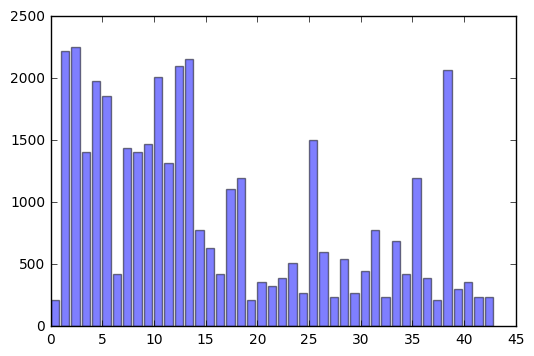

In [6]:
# Create a barchart of frequencies
item, count = np.unique(y_train, return_counts=True)
freq = np.array((item, count)).T

print('%d Observations' % (y_train.shape[0]))
plt.bar(item, count, alpha=0.5)

It is evident that about half of the classes in the dataset do **not** have nearly as many examples as we would want when training a model. It is my judgement that a model trained on this dataset would not have enough examples to accuratly distinguish between classes 0 and 1, for example. 

However, if this dataset represents the true proportions of class frequencies in the real world, we would not want to have an equal bias for class 0 and class 1. When the model is **uncertain**, we want it to predict class 1 (which is more frequent in the real world), but we also want it to be **capable** of predicting class 0. There is a fine line between inserting representational capability or non-exsistant bias into a model when augmenting a dataset.

When we address this issue later, I will outline my attempt to resolve it.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

### Implementation

Using the normalization method outlined above, we create the function `pre_process_gray` to generalize the mthon to multiple images. We also create functions to one-hot encode and de-one-hot encode the labels.

In [7]:
def pre_process_gray(images):
    # Convert images to grayscale
    tmp = []
    for i in range(images.shape[0]):
        gray = cv2.cvtColor(images[i,...], cv2.COLOR_BGR2GRAY)
        gray = cv2.equalizeHist(gray)
        norm_grey = gray/255. - 0.5
        tmp.append(norm_grey)
        
    tmp = np.array(tmp)
    return tmp[...,np.newaxis]

def one_hot(array):
    if array.ndim > 1: return array
    return np.array([[1 if j == array[i] else 0 for j in range(n_classes)] \
                     for i in range(len(array))])

def de_one_hot(array):
    if array.ndim == 1: return array
    return np.array([i.argmax() for i in array])

If everything works as expected, we expect the images to have shape (N, 32, 32, 3) to start, and (N, 32, 32, 1) to end. We will one-hot encode the labels at a later time, as they are easier to handle in a one-dimensional form.

In [8]:
print("Original Data Dims:\nData: %r | Labels: %r\n" % (X_train.shape, y_train.shape))

X_train = pre_process_gray(X_train)
print("Pre-Processed Data Dims:\nData: %r | Labels: %r\n" % (X_train.shape, y_train.shape))

Data Dims:
Data: (39209, 32, 32, 1) | Labels: (39209,)



### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**  
The first step I took to pre-process the images was to convert them to grayscale. I chose to convert them to grayscale by a process of elimination. E.G. the grayscale images performed better :) 

Once converted, I noticed that there was varying brightness between images, so I researched methods to normalize these descrepancies. The method I chose to use was equalizing the histogram of the image, as it was easy to implement with cv2 and it did not rely on global training set data, reducing the chance of data snooping occuring during testing.

Lastly, I normalized the pixel range to between [-0.5, 0.5] to create a well-conditioned problem for the optimizer to converge to a solution. 

At a later time, I will one-hot encode the labels. I am leaving them as-is for now to make life simpler when expanding the dataset.

### Data Augmentation and Test/Validation Setup

Now that our images are transformed and normalized, we need to expand the dataset to give the model a better chance of converging to a solution. 

When viewing an object from a fixed viewpoint, we can simulate the view of the same object from a **different** viewpoint by using affine transformations. Affine transformations are any linear transformation of a matrix which maintains the parrallelism of the lines in the image. Examples of such transformations include rotation, translation, and shear.

Using a function created by Vivek Yadav, we will create randomized transformations of our training images to simulate viewing the traffic signs from different angles, with the hope that this will make our model more robust in classification of new images.

*Function to create random transformations of an image. Credit to Vivek Yadav.*

In [9]:
def transform_image(img,ang_range,shear_range,trans_range):
    """
    This function transforms images to generate new images.
    
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    """
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

Let's test the function on a random image to see it's effect.

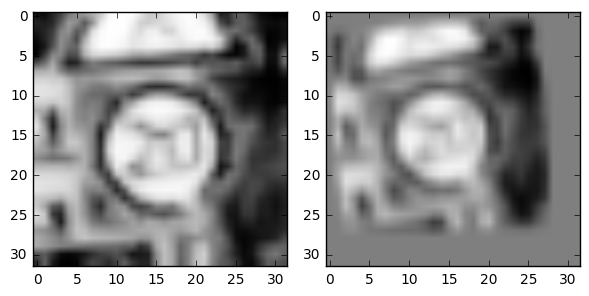

In [10]:
im = 0

transformed = transform_image(X_train[im,...], 20, 10, 5)
stacked = np.dstack((X_train[im,...], transformed))

grid = plt.subplot(1,2,1)
plt.imshow(stacked[...,0], cmap='gray')

grid = plt.subplot(1,2,2)
plt.imshow(transformed, cmap='gray')

plt.tight_layout()

Perfect! Now that we have a method to expand the dataset in a pricipled manner, we need to decide what classes to expand and by how much. Recall the class distribution chart from earlier. Many classes had fewer than 250 observations, making it unlikely that our model will predict these classes correctly. However, we do not want to mess with the distribution of the classes **too** much, as we must assume that the inherent bias in observation size corresponds to the probability of observing that sign on a road.
  
So, it's evident that we would like to expand the small classes by a lot to make the model recognize them, and the large classes by a little so as to simulate the different viewing angles. The first thing we need to do is segregate each class into its own dataset, and then expand that set by a varying amount based upon its size. Lastly, we need to recombine these class sets into our newly augmented training dataset!

In [11]:
segregated_data = []
class_obs = []

for class_ in range(n_classes):
    segregated_class = X_train[y_train == class_,...]
    segregated_data.append(segregated_class)
    class_obs.append(segregated_class.shape[0])

The scaling factors I chose were as follows:
* If <250 observations, increase size by 8x
* If <500 observations, increase size by 4x
* Else, increase size by 2x

In [12]:
def expand_class(images, n_obs):
    transformed_images = []
    
    if n_obs < 500: factor = 8
    elif n_obs < 1000: factor = 4
    else: factor = 2
    
    for image in images:
        for _ in range(factor-1):
            transformed_images.append(transform_image(image, 20, 10, 5))
    
    transformed_images = np.array(transformed_images)
    transformed_images = transformed_images[...,np.newaxis]
    expanded_class = np.concatenate((images, transformed_images), axis=0)
    return (expanded_class, expanded_class.shape[0])

In [13]:
expanded_data = None
expanded_labels = None

for class_, images in enumerate(segregated_data):
    if expanded_data is None:
        expanded_data, obs = expand_class(images, class_obs[class_])
        expanded_labels = np.full(obs, class_, dtype='int64')
    else:
        tmp, obs = expand_class(images, class_obs[class_])
        expanded_data = np.concatenate((expanded_data, tmp), axis=0)
        expanded_labels = np.concatenate((expanded_labels, np.full(obs, class_, dtype='int64')), axis=0)

del segregated_data, class_obs
print("Expanded Data Dims:\nData: %r | Labels: %r\n" % (expanded_data.shape, expanded_labels.shape))

Expanded Data Dims:
Data: (123296, 32, 32, 1) | Labels: (123296,)



All in all, we expanded our training dataset from 39,209 observations, to 123,296 observations. But did the classes scale as we expected them to, with smaller classes expanding more than larger classes? Lets take another look at the bar-chart and see how we fared.

123296 Observations


<Container object of 43 artists>

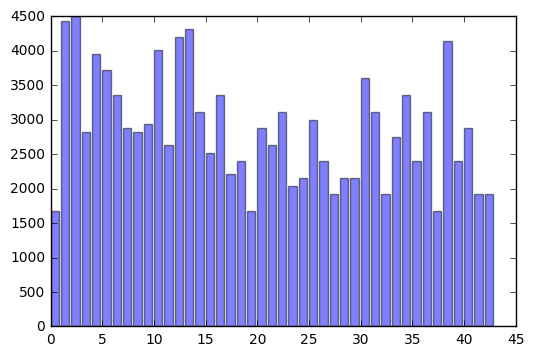

In [14]:
# Create a barchart of frequencies
item, count = np.unique(expanded_labels, return_counts=True)
freq = np.array((item, count)).T

print('%d Observations' % (expanded_labels.shape[0]))
plt.bar(item, count, alpha=0.5)

Looking good! Our class distribution is **much** more regular now! Now all that's left to do is split this data into training and validation sets. Below are some methods I created to shuffle the dataset, as currently it is ordered by class, and split a dataset into two sets with N% and (1-N)% in each, respectively.

In [15]:
def shuffle(X, y=None):
    """
    Given data (X) and labels (y), randomly shuffles their order.
    """
    X_shuffled, y_shuffled = [],[]
    n_obs = X.shape[0]

    for i in np.random.permutation(n_obs):
        X_shuffled.append(X[i,...])

        if y is None: y_shuffled.append(0)
        else: y_shuffled.append(y[i,...])
    return (np.array(X_shuffled), np.array(y_shuffled))

def train_val_split(data, labels, train_percent):
    n_obs = data.shape[0]
    assert n_obs == labels.shape[0], "Different number of images and labels"
    
    data, labels = shuffle(data, labels)
    
    cutoff = np.round(train_percent * n_obs).astype('int64')
    
    train = (data[:cutoff,...], labels[:cutoff])
    val = (data[cutoff:,...], labels[cutoff:])
    
    assert train[0].shape[0] + val[0].shape[0] == n_obs, "I fucked up"
    return (train, val)

In [16]:
train_percent = 0.8

expanded_labels = one_hot(expanded_labels)
train, val = train_val_split(expanded_data, expanded_labels, train_percent)

X_test, y_test = pre_process_gray(X_test), one_hot(y_test)
test = (X_test, y_test)

print("Train Size: %d | Val Size: %d | Test Size: %d"
     % (train[0].shape[0], val[0].shape[0], test[0].shape[0]))

Train Size: 98637 | Val Size: 24659 | Test Size: 12630


And now we **finally** get to use the `one_hot` method we created earlier! After all is said and done, we have 72.5% of our data in the train set, 18.1% in our validation set, and 9.3% in our test set. We also made sure to leave the data in the test set **untouched** (excepting preprocessing), so we can compare our results to others work.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**  
Summarizing from above, I used affine transformations to generalize training images to different viewpoints, expanded classes with fewer observations more than classes with higher observations, shuffled the dataset, and split the expanded training set 80/20 into train/validation sets. I left the testing set untouched except for the preprocessing, which did not use any information external to the set, avoiding data snooping.

# Time to Train the Model

Now that all of the preliminary steps have been completed, we can get to model construction and training. To make my life easier when iterating through model structures, I created a class `ConvNet` in the **models.py** file contained in this directory. The class automates the setup, training, and scoreing of a convolutional neural network in TensorFlow. I like to think of it as my own tiny Keras :) 

You can run `?ConvNet` after importing it to get a more thourough explanation of its functionality. For some reason, jupyter notebooks wont print docstrings inline...

In [17]:
def leaky_relu(x, alpha=0.1):
    import tensorflow as tf
    
    alpha = tf.constant(alpha)
    return tf.maximum(alpha*x, x)

Leaky RELU activations solve the issue of vanishing gradients in the normal RELU activation. TensorFlow does not provide an implementation by default, so we create our own.

In [18]:
from models import ConvNet

SignClassifier = ConvNet(batch_size=64, color_channels=1, image_shape=(32,32), 
                         n_classes=43, learning_rate=1e-3)

SignClassifier.conv2d('L0', kernel_size=1, depth=3, ACTIVATION=leaky_relu)

SignClassifier.conv2d('L1_1', kernel_size=3, depth=32, input_padding=1, ACTIVATION=leaky_relu)
SignClassifier.conv2d('L1_2', kernel_size=3, depth=32, input_padding=1, ACTIVATION=leaky_relu)
SignClassifier.pool2d('MAX')

SignClassifier.conv2d('L2_1', kernel_size=3, depth=64, input_padding=2, ACTIVATION=leaky_relu)
SignClassifier.conv2d('L2_2', kernel_size=3, depth=64, input_padding=2, ACTIVATION=leaky_relu)
SignClassifier.pool2d('MAX')

SignClassifier.conv2d('L3_1', kernel_size=3, depth=128, input_padding=1, ACTIVATION=leaky_relu)
SignClassifier.conv2d('L3_2', kernel_size=3, depth=128, input_padding=1, ACTIVATION=leaky_relu)
SignClassifier.pool2d('MAX')

SignClassifier.fully_connected('FC1', 1024)
SignClassifier.fully_connected('FC2', 512)



### Question 3

*What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)*

**Answer:**  
I used a Convolutional Neural Network with architecture:
* Convolutional Layer: 3x3x32
* Convolutional Layer: 3x3x32
* Max Pooling Layer: 2x2 Kernel with step size of 2  
  
* Convolutional Layer: 3x3x64
* Convolutional Layer: 3x3x64
* Max Pooling Layer: 2x2 Kernel with step size of 2  
  
* Convolutional Layer: 3x3x128
* Convolutional Layer: 3x3x128
* Max Pooling Layer: 2x2 Kernel with step size of 2  
  
* Fully Connected Layer: 1024 Neurons
* Fully Connected Layer: 512 Neurons
* Output Layer: 43 Neurons  

I used Leaky-RELU activation functions.

In [19]:
SignClassifier.train(train, val, training_epochs=1000, l2_beta=0.001, threshold=0.982)

Starting training process:
 Epoch: 0032 | Validation Accuracy: 0.9829 | Change: 0.0060463553
Validation accuracy threshold reached!

Optimization Finished!! Training time: 00h:50m:41s


Normalized confusion matrix
Accuracy: 0.97118


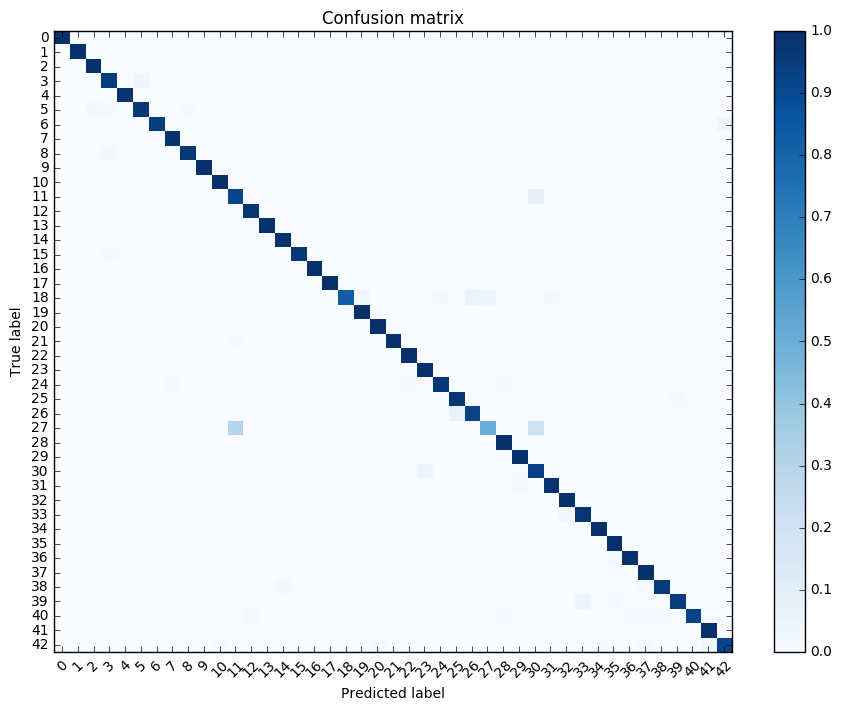

In [20]:
print("Accuracy: %1.5f" % (SignClassifier.score(test, plot=True, normalize=True)))

Not a bad result!! We achieved a 97.12% accuracy on our test set! Looking at the confusion matrix, we can see that the model has the most difficulty predicting class 27 (Pedestrians). We will analyze this performance leter in the notebook.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**  

**Optimizer:**  Adam Optimizer  
**Learning Rate:**  0.001  
**Batch Size:**  64  
**Beta for L2-Regularization:**  0.001  
**Max Epochs:** 100  
**Validation Accuracy Threshold:** 98.2%  

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**  
This project was very interesting and informative, and I learned a lot about the intricacies and implementation of convolutional neural networks in TensorFlow. I took quite a bit of inspiration from Vivek Yadav's [work](https://chatbotslife.com/german-sign-classification-using-deep-learning-neural-networks-98-8-solution-d05656bf51ad#.l55w6xh39) on this project. Using his techniques as a starting point, I was able to get very good results. However, I was not able to replicate his success due to environment issues with dropout.
  
My steps were mainly trial and error, alongside iterating on my ConvNet class to improve it's functionality and provide relevant information on the model performance. Once I had an architecture that was achieving good results, I tuned my hyperparameters as well as possible. The only limitations I faced were the issues with my environment and the time it took to train a model on my GTX 960.
  
Nonetheless, I am very pleased with the results I achieved and I will most likely come back to this project in the future to see if I can improve my accuracy.

---

## Step 3: Test the Model on New Images

Now that we have a fully trained model, let's see how it performs on images taken from outside the dataset. I went online and downloaded 6 images of various traffic signs, and we will go through the steps of transforming their shape and predicting their class below.

### Loading and Transforming the Images

I placed the testing images in their own directory `test_images`. Since these images were downloaded from google, they are not as nicely formatted as our original dataset. The first thing we need to do is ensure that the images are 32x32x3 so we can pre-process and feed them into our model. Once this is done, we can apply the same pre-processing as our original dataset, using our `pre_process_gray` function.

In [21]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import matplotlib.pyplot as plt
import cv2

test_images = []
path = './test_images/'
for image in os.listdir(path):
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    test_images.append(img)

test_images = np.array(test_images)
test_images = pre_process_gray(test_images)

Let's take a look at what the images look like now!

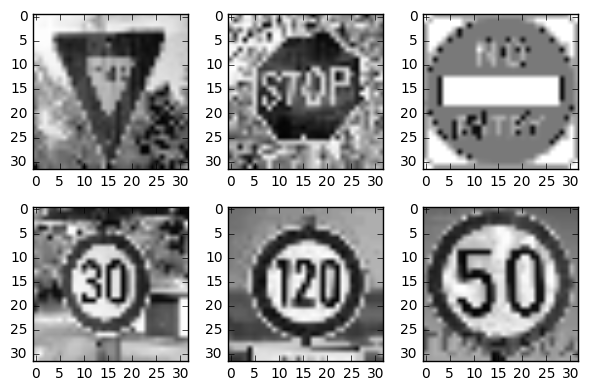

In [22]:
fig = plt.figure()

for i, image in enumerate(test_images):
    grid = plt.subplot(2,3,i+1)
    grid.imshow(image[...,0], cmap='gray')

plt.tight_layout()
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**  
For the Yeild and Stop signs, the noise in the backgroud from the trees/foliage could confuse the model. For the No Entry sign, the noise over the words on the sign may prevent it from converging to the correct label. For the Speed signs, I do not see any reason why the model would not predict these correctly.

Now that we have the images loaded and pre-processed, all that's left to do is create an array with their labels and see how the model performs!

In [23]:
import pandas as pd

labels = np.array([13, 14, 17, 1, 8, 2])
pred = [i.argmax() for i in SignClassifier.predict(test_images)]

df = pd.DataFrame(data=np.array((labels, pred)).T, columns=['Labels', 'Predictions'])
acc = SignClassifier.score((test_images, one_hot(labels)))

print('Accuracy: %1.5f\n\n' % (acc), df)

Accuracy: 0.83333

    Labels  Predictions
0      13           13
1      14           14
2      17           14
3       1            1
4       8            8
5       2            2


### Question 7

*Is your model able to perform equally well on captured pictures when compared to testing on the dataset?*

**Answer:**  
The short answer is no :) HOWEVER, given the small amount of testing samples, we can't know for sure unless we get a larger sample size. My model correctly predicted 5/6 of the testing samples, or 83.33%. This is compared to the 97.12% accuracy achieved on the in-sample testing set. Given that there is no possible way to achieve 97% accuracy on 6 samples, I am happy with the models performance.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions.*

To analyze what went wrong with the No Enter sign, lets take a look at the top 5 probabilities that the model predicted:

In [24]:
def vizualize_softmax_probabilities(model, image, num_probs):
    import pandas as pd
    import matplotlib.pylab as plt
    
    if image.ndim == 3:
        image = image[np.newaxis,...]
    if image.shape[3] > 1:
        image = pre_process_gray(image)
    
    pred = model.predict(image)[0]
    top_k = np.argsort(pred)[:-(num_probs+1):-1]
    
    pred = pd.DataFrame(data=np.array((top_k, pred[top_k])).T, columns=['ClassId', 'Probability'])
    names = pd.read_csv('./signnames.csv', header=0)
    pred = pd.merge(pred, names, how='inner', on='ClassId')
    
    fig = plt.figure(figsize=(11,7))
    grid = plt.subplot(1,2,1)
    plt.imshow(image[0,:,:,0], cmap='gray')
    
    grid = plt.subplot(1,2,2)
    plt.barh(np.arange(num_probs)[::-1], np.array(pred['Probability']), align='center')
    plt.xlim([0,1.0])
    plt.yticks(np.arange(num_probs)[::-1], np.array(pred['SignName']))
    
    plt.tight_layout()

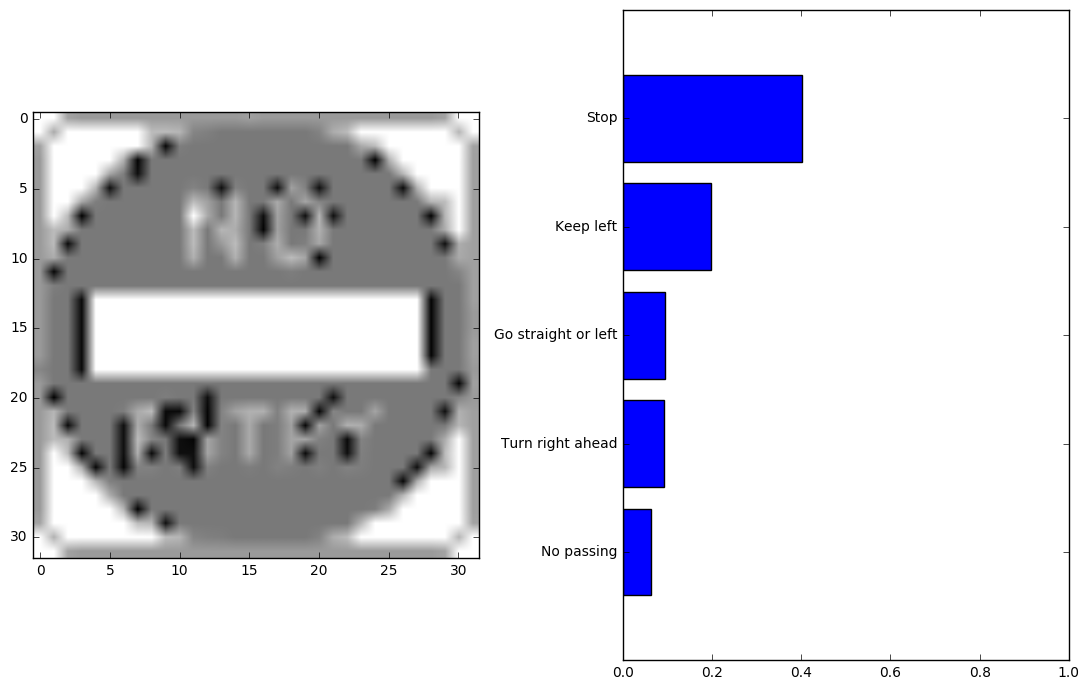

In [32]:
vizualize_softmax_probabilities(SignClassifier, test_images[2], num_probs=5)

As we can see, the model is **completely** confused by this image :) It has the vague shape of a stop sign, but the model is unsure of what to think about it. Unfortunately, the correct prediction isn't even in the top 5. However, the model is nearly 100% confident about it's predictions for the other 5 images in the test set!

In [ ]:
vizualize_softmax_probabilities(SignClassifier, test_images[0], num_probs=5)

In [ ]:
vizualize_softmax_probabilities(SignClassifier, test_images[1], num_probs=5)

In [ ]:
vizualize_softmax_probabilities(SignClassifier, test_images[5], num_probs=5)

As a final step, let's take a look at some incorrectly classified images from our non-googled testing set, preferably with class 27 to analyze the main source of our error.

In [2]:
# TODO: Give 3 examples of incorrectly classified images. Two with class 27.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.